In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiData import gmiData
import os
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
from matplotlib import ticker

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

#quantiles         = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])
quantiles         = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

batchSize         = 256

depth             = 4
width             = 256
convergence_epoch = 5
maximum_epoch     = 40

inputs            = 5

In [3]:
inChannels = np.array(['166.5V', '166.5H', '183+-3', '183+-7'], dtype=object)


In [4]:
def train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data):
        qrnn = QRNN(inputs, quantiles, (depth, width , "relu"))
        for lr in [0.01, 0.001, 0.0001]:
            print ("NEW LEARNING RATE")
            results = qrnn.train(
                training_data,
                validation_data,
                batch_size=batchSize,
                momentum = 0,
                sigma_noise=None,
                initial_learning_rate= lr ,
                maximum_epochs=maximum_epoch,
                convergence_epochs= convergence_epoch,    
                gpu=True)

        return results, qrnn

### read data

In [6]:

data = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train.nc"), inChannels,
               batch_size = batchSize) 
n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train

training_data, validation_data = random_split(data, [n_train, n_val])
results = []

In [6]:
 



results, qrnn = train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data)



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE


In [7]:
qrnn.save('try/qrnn_gmi_iwp.nc')

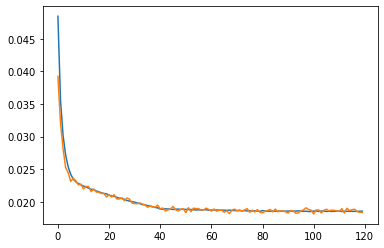

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(results['training_errors'])
ax.plot(results['validation_errors'])


### plot calibration plot

Text(0, 0.5, 'Observed frequency')

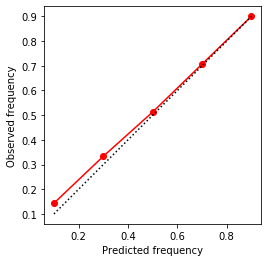

In [7]:
qrnn =  QRNN.load('try/qrnn_gmi_iwp.nc')
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")

In [8]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_pre.append(qrnn.predict(x)) 
    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)

408


In [9]:
x_in = np.concatenate(x_in, axis = 0)
y_pre = np.concatenate(y_pre, axis = 0)
y = np.concatenate(y, axis= 0)
y_pos_mean = np.concatenate(y_pos_mean, axis = 0)

Text(0.5, 0, 'IWP[kg/m2]')

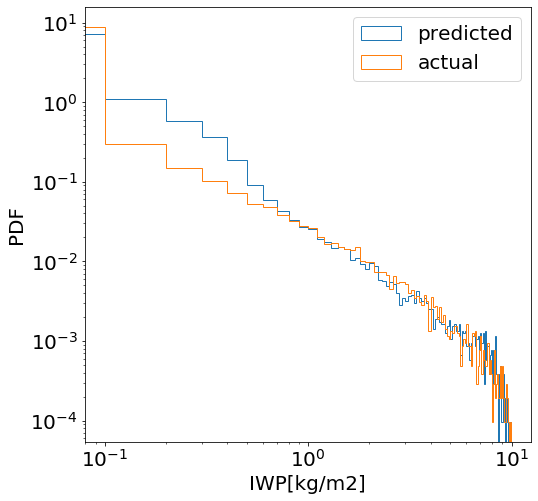

In [10]:
plt.rcParams.update({'font.size': 20})
bins1 = np.arange(0, 10, 0.1)
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
ax.hist(y_pos_mean, bins1, density = True , histtype = "step", label = "predicted")


ax.hist(y, bins1, density = True, histtype = "step", label = "actual")
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()
ax.set_ylabel("PDF")
ax.set_xlabel("IWP[kg/m2]")

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Log scale: values of z <= 0 have been masked
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, 'IWP Observed [kg/m2]')

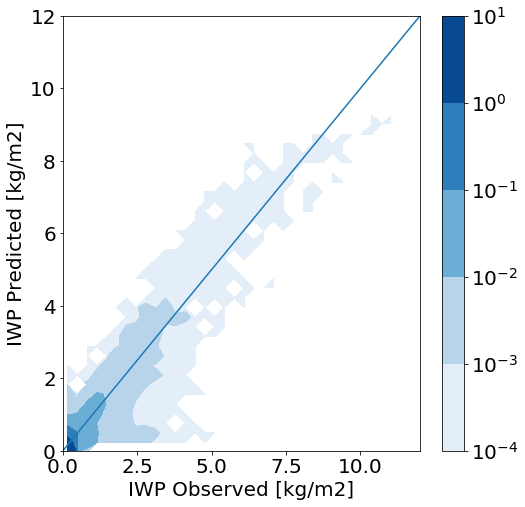

In [32]:
from iwc2tb.common.hist2d import hist2d

hh, xyrange, xdat1, ydat1 = hist2d(y, y_pos_mean, bins = [45, 45])

    
#hh[hh < thresh] = np.nan # fill the areas with low density by NaNs
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
cs = ax.contourf(np.flipud(hh.T), cmap= 'Blues',
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
cbar = fig.colorbar(cs)  
ax.plot(xdat1, ydat1, '.',color='blue', alpha = 0.2)
ax.set_ylim([0, 12])
ax.set_xlim([0, 12])
xy = np.arange(0, 13, 1)
yy = xy
ax.plot(xy, yy)
ax.set_ylabel("IWP Predicted [kg/m2]")
ax.set_xlabel("IWP Observed [kg/m2]")

array([], dtype=float32)

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  


Text(0.5, 0, 'IWP Observed [kg/m2]')

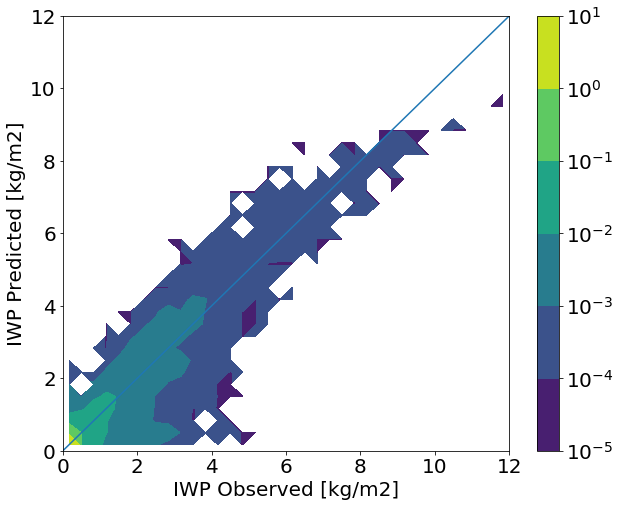

In [11]:
import scipy
from matplotlib import ticker, cm
xyrange = [[0, 15], [0, 15]] # data range

bins = [45, 45] # number of bins
hh, locx, locy = np.histogram2d(y, y_pos_mean, 
                                range=xyrange, bins=bins, density = True)
posx = np.digitize(y, locx)
posy = np.digitize(y_pos_mean, locy)

fig, ax = plt.subplots(1, 1, figsize = [10, 8])
cs = ax.contourf(np.flipud(hh.T),
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
cbar = fig.colorbar(cs)
ax.set_ylim([0, 12])
ax.set_xlim([0, 12])
xy = np.arange(0, 13, 1)
yy = xy
ax.plot(xy, yy)
ax.set_ylabel("IWP Predicted [kg/m2]")
ax.set_xlabel("IWP Observed [kg/m2]")
#ax.set_yscale('log')
#ax.set_xscale('log')